# Dataset - Neural Networks

In this document, I will go over preparing the training/testing data to be used in PyTorch-based models.

In [11]:
# - preparing the master dataframe
from typing import List, Tuple
import os
import random
import numpy
import pandas
import matplotlib.pyplot as plt
import torch
import torch.utils.data.dataset
import torch.utils.data.dataloader


dataset_url = 'https://figshare.com/ndownloader/files/35249488'
# - getting the dataset
cache_path = os.path.abspath('../resources/raw_data/dataset.pkl')
if os.path.isfile(cache_path):
    df = pandas.read_pickle(cache_path)
else:
    df = pandas.read_csv(dataset_url).drop(columns=['Unnamed: 0'])
    df.to_pickle(cache_path)

In [12]:
df_meta = df.copy()

In [13]:
df_meta = df_meta.loc[:, ['PatientID', 'Gender', 'Ethnic']].groupby('PatientID').first().reset_index()
df_meta.head()

,PatientID,Gender,Ethnic
0,0,1.0,4.0
1,1,1.0,3.0
2,2,1.0,4.0
3,3,1.0,4.0
4,4,1.0,3.0


In [14]:
df_meta.shape

(8916, 3)

## Splits

Given the nature of the problem, I will use patient ID as item identifier and perform stratified splitting based on the key demographics that are available (Gender and Ethnicity).

If the other features indicate things such as "pre-existing conditions" it could be better to consider those as well (so as to not end up with a all very diseased people being in the test set, and so on.)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
df_train_meta, df_test_meta = train_test_split(
    df_meta,
    test_size=0.2,
    shuffle=True,
    random_state=29,
    stratify=df_meta.loc[:, ['Gender', 'Ethnic']]
)

In [17]:
assert len(set(df_train_meta.PatientID.unique()).intersection(df_test_meta.PatientID.unique())) == 0

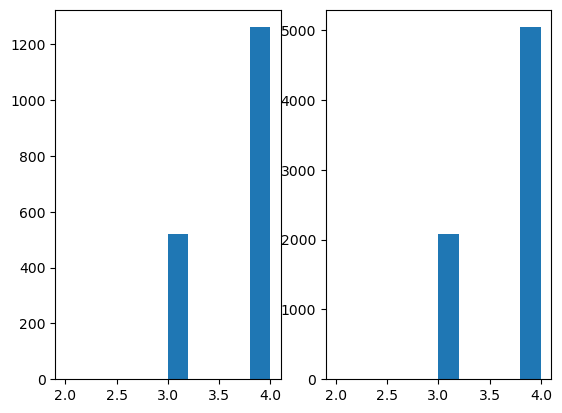

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].hist(df_test_meta.Ethnic)
axes[1].hist(df_train_meta.Ethnic)
plt.show()

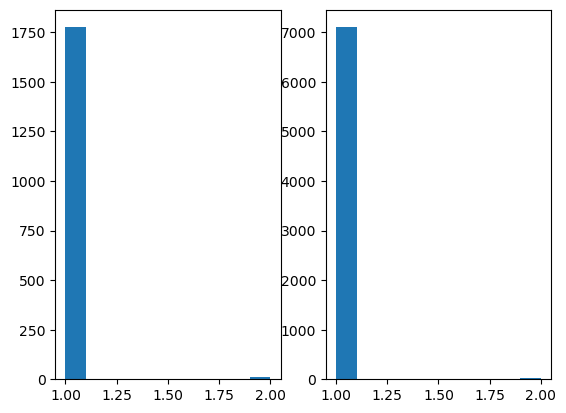

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].hist(df_test_meta.Gender)
axes[1].hist(df_train_meta.Gender)
plt.show()

In [20]:
df_test = pandas.merge(df, df_test_meta, on=['Gender','Ethnic', 'PatientID'], how='right')
df_train = pandas.merge(df, df_train_meta, on=['Gender','Ethnic', 'PatientID'], how='right')

In [21]:
assert len(set(df_train.PatientID.unique()).intersection(df_test.PatientID.unique())) == 0

In [63]:
class NNRTIDataset(torch.utils.data.dataset.Dataset):
    def __init__(
            self,
            df: pandas.DataFrame,
            seq_len_options: List[Tuple[int, int]],
            shuffle: bool = False,
    ):
        self.df = df.copy()

        # - compute the identifiers, namely, list of tuples of patientid, start_timepoint, and length
        self.patient_ids = sorted(self.df.PatientID.unique().tolist())
        if shuffle:
            random.shuffle(self.patient_ids)

        self.seq_options = []
        for seq_len, stride in seq_len_options:
            for i in range(0, 60-seq_len, stride):
                self.seq_options.append(
                    (i, seq_len)
                )

        self.df.set_index(['PatientID', 'Timepoints'], inplace=True)


    def __len__(self):
        return len(self.patient_ids) * len(self.seq_options)
    

    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx % len(self.patient_ids)]
        i_start, seq_len = self.seq_options[idx // len(self.patient_ids)]
        
        tmp = self.df.loc[[
            (patient_id, i_start + i) for i in range(seq_len)
        ]].copy()

        static_features = tmp.loc[:, ['Gender', 'Ethnic']].iloc[0].to_numpy()

        seq_categorical = tmp.loc[:, [
            'Base Drug Combo',
            'Extra PI',
            'Extra pk-En',
            'VL (M)',
            'CD4 (M)',
            'Drug (M)',
            'Comp. NNRTI',
            'Comp. INI',
        ]].to_numpy()

        seq_numerical = tmp.loc[:, [
            'VL', 
            'CD4', 
            'Rel CD4',
        ]].to_numpy()

        return dict(
            tmp=tmp,
            static_features=static_features,
            seq_numerical=seq_numerical,
            seq_categorical=seq_categorical
        )



        

In [71]:
dataset = NNRTIDataset(
    df=df_train,
    seq_len_options=[(5, 5), (10, 10), (20, 20)],
    shuffle=True
)

In [72]:
dataset[2]['tmp']

VL        CD4    Rel CD4  Gender  Ethnic  \
PatientID Timepoints                                                     
4892      0           5931.96700  857.49540  30.215862     1.0     4.0   
          1           1078.53870  341.30185  33.743225     1.0     4.0   
          2            405.95900  271.12080  25.063938     1.0     4.0   
          3             25.97034  617.20276  35.737760     1.0     4.0   
          4           1229.81420  231.11073  26.807066     1.0     4.0   

                      Base Drug Combo  Comp. INI  Comp. NNRTI  Extra PI  \
PatientID Timepoints                                                      
4892      0                       1.0        0.0          3.0       5.0   
          1                       1.0        0.0          3.0       5.0   
          2                       1.0        0.0          3.0       5.0   
          3                       1.0        3.0          3.0       5.0   
          4                       1.0        0.0          3.0       5.0   

                      Extra pk-En  VL (M)  CD4 (M)  Drug (M)  
PatientID Timepoints                                          
4892      0                   0.0     1.0      1.0       0.0  
          1                   0.0     0.0      0.0       0.0  
          2                   0.0     1.0      1.0       1.0  
          3                   0.0     0.0      0.0       1.0  
          4                   0.0     1.0      1.0       0.0

In [73]:
dataset[2]['static_features']

array([1., 4.])

In [74]:
dataset[2]['seq_categorical']

array([[1., 0., 5., 0.],
       [1., 0., 5., 0.],
       [1., 0., 5., 0.],
       [1., 3., 5., 0.],
       [1., 0., 5., 0.]])

In [75]:
dataset[2]['seq_numerical'].shape

(5, 10)

In [77]:
len(dataset)#// 256

128376